In [0]:
%pip install textblob

Python interpreter will be restarted.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-f63bf16c-9eb8-40d2-9565-b3ccca0411d3/bin/python -m pip install --upgrade pip' command.
Python interpreter will be restarted.


In [0]:
%pip install mlxtend

Python interpreter will be restarted.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-f63bf16c-9eb8-40d2-9565-b3ccca0411d3/bin/python -m pip install --upgrade pip' command.
Python interpreter will be restarted.


In [0]:
%sh
pip install wordcloud

You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-f63bf16c-9eb8-40d2-9565-b3ccca0411d3/bin/python -m pip install --upgrade pip' command.


In [0]:
%run ./includes/set_up

In [0]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download("popular")

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from pyspark.sql.functions import *

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.
[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping c

# Anisah

In [0]:
anisahBusinessDFClean = spark.read.parquet("/FileStore/tables/Anisah_files/anisahBusinessDFParquet")

## #1 - By State

In [0]:
from pyspark.sql.functions import col, split, explode, trim
subCatBizDF = anisahBusinessDFClean.select(col("business_id"), split(col("categories"),",").alias("categories1"))
subCatBizDF = subCatBizDF.select(subCatBizDF.business_id,explode(subCatBizDF.categories1))
subCatBizDF = subCatBizDF.withColumn("col", trim(col("col")))

subCatBizDF.createOrReplaceTempView("business_category_temp_view")
subCatBizDF = subCatBizDF.withColumnRenamed("col","sub_categories")
subCatCountsDF = subCatBizDF.groupBy("sub_categories").count()
subCatCountsDF = subCatCountsDF.sort(col("count").desc())
restBizDF = subCatBizDF.filter(col("sub_categories") == "Restaurants")
subBizDF = anisahBusinessDFClean.select(col("business_id"), col("state"), col("city"), col("name"), col("overall_stars"))
subRestBizDF = (subBizDF.join(restBizDF,"business_id","outer"))
subRestBizDF = subRestBizDF.na.drop()
countRestStateDF = subRestBizDF.groupBy("state").count()
countRestStateDF = countRestStateDF.select("state", col("count").alias("no_of_restaurants")).distinct()
countRestStateDF = countRestStateDF.sort(col("count").desc())
countRestStateDF.display()

state no_of_restaurants MA 6458 FL 5394 BC 4728 OR 4224 GA 3919 TX 3153 OH 3103 WA 532 CO 497 KY 1 NH 1 ABE 1 VA 1 KS 1 WY 1 MN 1

In [0]:
countRestStateDF.display()

state no_of_restaurants MA 6458 FL 5394 BC 4728 OR 4224 GA 3919 TX 3153 OH 3103 WA 532 CO 497 KY 1 NH 1 ABE 1 VA 1 KS 1 WY 1 MN 1

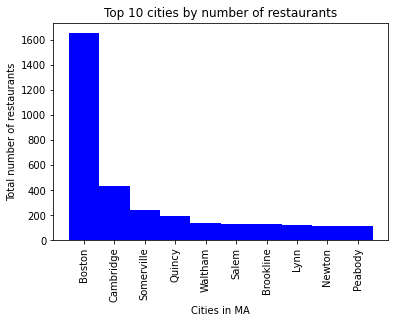

In [0]:
rankMACityDF = subRestBizDF.filter(col("state") == "MA").sort(col("city").desc())
rankMACityDF = rankMACityDF.groupBy("city").count()
rankMACityDF = rankMACityDF.sort(col("count").desc()).limit(10)
import matplotlib.pyplot as plt

plt.figure()
rankMACityDF = rankMACityDF.toPandas()
plt.bar(rankMACityDF["city"], rankMACityDF["count"], width=1, color="b")
plt.title("Top 10 cities by number of restaurants")
plt.xlabel("Cities in MA")
plt.ylabel("Total number of restaurants")
plt.xticks(rotation=90)
plt.show()

## #2 - By Star Rating

In [0]:
starsCountDF = subRestBizDF.groupBy("overall_stars").count()
starsCountDF.sort(col("overall_stars").desc()).display()

overall_stars count 5.0 1018 4.5 4954 4.0 8760 3.5 7550 3.0 4548 2.5 2588 2.0 1719 1.5 742 1.0 136

In [0]:
starsCountPDF = starsCountDF.toPandas()

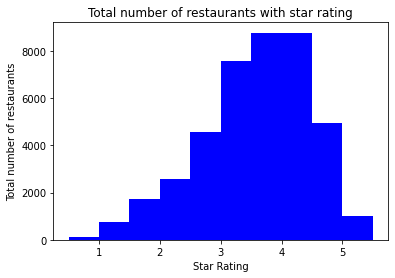

In [0]:
import matplotlib.pyplot as plt

plt.figure()
plt.bar(starsCountPDF["overall_stars"], starsCountPDF["count"], width=1, color="b")
plt.title("Total number of restaurants with star rating")
plt.xlabel("Star Rating")
plt.ylabel("Total number of restaurants")
plt.show()

In [0]:
avgStarsDF = subRestBizDF.groupBy("state").avg("overall_stars")
avgStarsDF = avgStarsDF.select("state", col("avg(overall_stars)").alias("avgOverallStars"))
display(avgStarsDF)

state avgOverallStars OR 3.7803030303030303 BC 3.4821277495769882 WA 3.4586466165413534 OH 3.4242668385433452 TX 3.6860133206470027 GA 3.4138810921153357 MA 3.5537318055125424 FL 3.511401557285873 CO 3.704225352112676 KY 2.0 NH 4.0 ABE 4.5 KS 2.0 WY 1.5 MN 3.5 VA 2.0

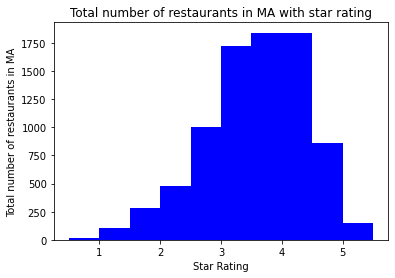

In [0]:
rankMAStarsDF = subRestBizDF.filter(col("state") == "MA").sort(col("overall_stars").desc())
rankMAStarsDF = rankMAStarsDF.groupBy("overall_stars").count()
plt.figure()
rankMAStarsPDF = rankMAStarsDF.toPandas()
plt.bar(rankMAStarsPDF["overall_stars"], rankMAStarsPDF["count"], width=1, color="b")
plt.title("Total number of restaurants in MA with star rating")
plt.xlabel("Star Rating")
plt.ylabel("Total number of restaurants in MA")
plt.show()

## #3 - By Cuisine

In [0]:
#List of cuisines in the data
list_of_cuisines = ["African", "American (Traditional)", "Asian Fusion", "Australian", "Brazilian", "Cantonese", "Chinese", "Cuban", "French", "German", "Greek", "Hawaiian", "Indian", "Indonesian", "Italian", "Japanese", "Korean", "Lebanese", "Malaysian", "Mediterranean", "Mexican", "Middle Eastern", "Pakistani", "Shanghainese", "Singaporean", "Spanish", "Taiwanese", "Thai", "Turkish", "Vietnamese"]

In [0]:
cuisineDF = subCatBizDF.select(col("business_id"), col("sub_categories"))
cuisineDF = cuisineDF.withColumnRenamed("sub_categories", "cuisine")
cuisineDF = cuisineDF.filter(cuisineDF.cuisine.isin(list_of_cuisines))
subCuiRestDF = subRestBizDF.select("business_id", "state", "city")
subCuiRestDF = (subCuiRestDF.join(cuisineDF,"business_id","outer"))
subCuiRestDF = subCuiRestDF.na.drop()
subCuiRestDF = subCuiRestDF.select("state", "city", "cuisine")
subCuiRestDF = subCuiRestDF.sort(col("state").asc())
subCuiRestMADF = subCuiRestDF.filter(col("state") == "MA")
subCuiRestMADF = subCuiRestDF.drop(col("city"))
subCuiRestMADF = subCuiRestDF.groupBy("cuisine").count()
subCuiRestMADF = subCuiRestMADF.sort(col("cuisine").desc())
display(subCuiRestMADF)

cuisine count Vietnamese 698 Turkish 83 Thai 796 Taiwanese 192 Spanish 199 Singaporean 27 Shanghainese 11 Pakistani 182 Middle Eastern 488 Mexican 2815 Mediterranean 890 Malaysian 58 Lebanese 111 Korean 525 Japanese 1772 Italian 2128 Indonesian 17 Indian 605 Hawaiian 177 Greek 443 German 62 French 267 Cuban 127 Chinese 2328 Cantonese 77 Brazilian 129 Australian 11 Asian Fusion 1235 American (Traditional) 4377 African 131

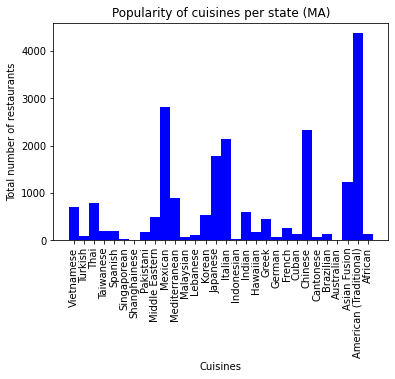

In [0]:
plt.figure()
subCuiRestMADF = subCuiRestMADF.toPandas()
plt.bar(subCuiRestMADF["cuisine"], subCuiRestMADF["count"], width=1, color="b")
plt.title("Popularity of cuisines per state (MA)")
plt.xlabel("Cuisines")
plt.ylabel("Total number of restaurants")
plt.xticks(rotation=90)
plt.show()

# Bryan

In [0]:
sentimentDF.select('business_id', 'review_stars', 'lemmatized', 'polarity', 'subjectivity').display()

business_id review_stars lemmatized polarity subjectivity c7GPtFk8fwAHJ2M0NxUi9g 3 pretty solid dependable food parking lot bit small big chunk reserved sleep country prepared wait spot peak time used valet service longer exists waiting area super large lot seating service hit miss sometimes super efficient friendly great time server seen food though always dependable good quality whether pasta burger bowl salad match location happy hour strong well good restaurant brentwood area 0.3607142857142857 0.5804029304029305 s7nGzW99-7Pm0MStfqKTMA 2 seemed completely forget cheese mac cheese extremely small think everything extremely well case poutine ok chicken wing good fried curry chicken sandwich bratwurst special quite poor drink order taken piecemeal 60 getting order taken rest waited took hour order second drink waitress seemed overwhelmed -0.03178571428571429 0.5971428571428571 BKWuI_2A6PPUYHXUnsE5tQ 1 thank god place finally closed god worse chili ever -0.25 0.35 0Fate990kUIou17XmytCjw 1 worst restaurant experience ever werent waited 20 minute seated asking front desk waitress put entire order served food drink salad breadstick asked bring food later let slip simply put warmer light time concealed cold waitress rude never apologized anything awful wish left saved ourself trouble -0.27 0.5482142857142857 jAZlPrPCk9w9MAwI6VcNUg 5 took son first haircut awesome give great haircut sweet kind nervous cry squirming around kept entertained giving cut amir cut hair definitely 0.5 0.6888888888888888 7t8AnQq-LlSJyXhbPNxlrg 5 really relaxing nice lunch airport restaurant longer normal layover server kenny attentive helpful handled large group without making feel like busy atlanta airport stop lunch dinner restaurant visit server kenny 0.2773809523809524 0.5797619047619047 2EnKNyqXVTAsG5V9VJNxxg 5 hosted bridal brunch rosemary room september service food impeccable room beautiful need decoration couldnt event successful convenient bride happy attendee 0.7875000000000001 0.925 -lPbwmwui7oKkSEAqqClGg 1 waited 13 min drive thru door order 2 steakburgers ridiculous car front get money never apologized flippant attitude saying cr busy talk customer laughed never ever 0.21666666666666667 0.6 yxQhi3H3DUtbNevO66Tsmw 5 misplaced country boy montana place reminds childhood year food like mamma used country hospitality several visit impressed server named dana give great service personable fun know want anticipates every need 0.38 0.43 bkjLcbXySwYZc_V6REZogA 4 gotten mexican taco burrito several occasion always delicious fast deliver ill try pizza time 0.13999999999999999 0.52 -uc_fagt--zUc_ahxzkyag 5 walk dont fooled see lot people family waiting haircut people waiting barber ask turning cheek 0.0 0.0 Gsz2J8RaD5Rf9UiMwQ9B7Q 1 people either thief incompetent maybe ticket yonder mountain string band last saturday 11232019 bought directly ymsbs site received email confirmation confirmation number instructed show confirmation call get box office wife mentioned serious issuesspinal fusion arthritis stenosis etc asked possibly get couple chair sit side needed girl booth 7pm asked ticket immediately rejected confirmation told needed bar code course confirmation number refused entry said buy two ticket wanted get since already 150 show extorted left contacted site linked thru ymsb shocked call confirmation rejected needle say definitely plan following maybe ada complaint order since ticket girl rejected mention need chair looking forward show three month wasted time money treated never co business venue mark r -0.1621212121212121 0.3727272727272727 q0aO5LqbYEk1gxa6ry8MZQ 5 gu bistro dined family friend number thanksgiving christmas gu kitchen still buford highway south 285 still atlanta hottest restaurant great schezwan cuisine different boring ubiquitous cantonese cuisine chinese restaurant -0.04999999999999999 0.5875 plEh_VdvGNzu2i-cwGDUHw 5 fresh food friendly staff poke bowl great return soooooon buy 1 get 1 fresh fruit smoothy worth trip bu 0.4150000

## Predictive Modeling

In [0]:
modelDF.display()

business_id state polarity subjectivity review_stars good_rating zuXG20HMicHXtli-ZIdTzw FL 0.18464781746031747 0.49191468253968257 4 1 PEARGMSjn_chFoyT8bORTQ MA 0.3527777777777778 0.5527777777777778 5 1 LicAOuevKgq5NbRE5-0Lnw OR 0.3328947368421053 0.5701754385964911 5 1 jtq2EwneZN2ktop1Ja11Sw BC 0.10952380952380954 0.6690476190476191 4 1 3CrAvu81KXQ31hdiL5_HTw GA 0.3304846938775511 0.5015306122448979 4 1 OQctqMNZUU3x2wE005GVjw OR 0.37999999999999995 0.6000000000000001 4 1 9l2YZ9KDnIOdBzhq0pW93Q OR 0.5833333333333333 0.37083333333333335 5 1 -CHazLwo2j2G8gWEZN53hA GA 0.17563311688311686 0.5391666666666666 4 1 QhhOFdwFrgHFjrUYlI67IA MA 0.5158333333333334 0.76 4 1 FXUP30Em30Itiuzfo4lDTA BC 0.28318181818181815 0.5622727272727273 5 1 2R7W7Ds9Qptw6tCzXdeS-Q GA 0.13541666666666669 0.45000000000000007 2 0 JabzTWXa8Qiw69Xi34NXmw MA -0.09583333333333333 0.5583333333333333 2 0 pW_4rwhwTrA_N-A_TFl34Q WA 0.27999999999999997 0.885 5 1 _b-5jG-H4g_h1lh3EF1gSQ OR 0.2857142857142857 0.5428571428571429 5 1 _7EcAl2OPXNm7UynPUJfoQ OH 0.19444444444444445 0.4222222222222222 4 1 HgV9w6HUulS2g7cDP1Vxvw MA 0.5892857142857143 0.5928571428571429 4 1 SRCpBVqcqoMdyJcJ8qJd8A MA 0.6833333333333335 0.6125 5 1 2091PR7MSnSb7t4roBLe3A GA 0.516060606060606 0.5990909090909091 5 1 rFPAYamNjdmOxVOtltz0AA BC 0.41875 0.625 5 1 bdtTr03naoUjIgjvCv-AOQ TX -0.010416666666666668 0.5133928571428571 1 0 i9KnzE5hjzxX9Z3fcWdjqg OH 0.16999999999999998 0.64 5 1 hS3gTLXM4nqgONL-lTnYTQ FL 0.31 0.555079365079365 4 1 Ow25F43JVpL_j1Gy5aG_Hg OR 0.46666666666666673 0.6166666666666667 5 1 dX6rFCSTInhIyt2ik7vgNA TX 0.030833333333333324 0.5266666666666666 2 0 yvWgHaRjKS5bPy4Hr_l-2Q WA 0.10624999999999998 0.3666666666666667 5 1 jA6sjFim2tUn9T5Ip1GNqw OR 0.5371428571428571 0.6826984126984127 5 1 X61Is14DjGAF04d6v2R66Q GA 0.34223484848484853 0.6621212121212122 5 1 63DRZg2CGsBifJ_WQfwEVg FL 0.5599999999999999 0.4800000000000001 4 1 y5uWMQyaEKFatn1IL6I_3A TX 0.4955555555555555 0.6599999999999999 5 1 xTnb6Q51TUye6CysLn7aEQ BC 0.32182539682539685 0.4992063492063492 3 0 azVXMFZzCZA6wrc46X9fnQ GA 0.43125 0.5361111111111112 5 1 PWlm_xOi2fkDlKM17LcRUQ MA -0.011111111111111096 0.5555555555555556 5 1 HHNS1GpxNO_X8xEXEE2Ocg WA 0.4225 0.7561111111111112 5 1 QDk7982qXeLUg9fAVIgpEg BC -0.07096560846560845 0.5866071428571428 3 0 _8vtC2Jo29HZwyNhQ3PWrg CO -0.17499999999999996 0.6944444444444445 4 1 s1x1-u3rYB2se2iQEMaPmg OR 0.29074074074074074 0.6833333333333333 5 1 HvtGWqaCdnE8k9PEVzhXKg MA 0.35119047619047616 0.6106349206349206 5 1 86w8qN8zIRqimOuaSYKEYA OR 0.4222222222222223 0.7166666666666667 5 1 oVOFZTfnmHmZz3IJ3uy1fQ OR 0.3842105263157895 0.45614035087719296 5 1 s3CZUhh30jsq8GSI4UJ3cg GA 0.15046296296296297 0.5069444444444444 1 0 BruO0vY9SwMt0JmnGn0tJw BC 0.15650406504065043 0.5812669376693766 2 0 _exUJQM8RsD2y-8Kzrx33g MA 0.2 0.2 2 0 f_ZMyBmqZZKH6VLg4QfOZA GA -0.14333333333333334 0.6633333333333333 1 0 f412zO5FpTiec9Z_Q0PtHg MA 0.25 0.65 5 1 OztN9An_uaa38MZZ2K8a_g MA 0.09960317460317458 0.616137566137566 3 0 eJ7X_8KXVlyHZtGrrLz4yg TX 0.6166666666666667 0.7333333333333333 5 1 97bK6WFJdJzy0oNNb3X6Hg TX 0.5333333333333333 0.65 4 1 uN8RKQbslr7qwjNqEFDXfw BC 0.31858974358974357 0.6352564102564102 5 1 EDm3EkIja4aNbCcxC8RKDw GA 0.31590909090909086 0.47261904761904766 5 1 _33gXTh_rPfk_jDYZphP2g TX 0.39285714285714285 0.6452380952380953 4 1 YAmtbEdsYzSm5NPurU_SaA FL 0.2888888888888889 0.5611111111111111 4 1 MKPaHFBweEnsWyjMmyawVg TX 0.3562629399585921 0.4899585921325051 5 1 VDSQSf6GgRk0Q9eZp1q1Gw MA 0.3371428571428572 0.5771428571428572 5 1 PE0pI19ZGifDxoSXYcgT5w TX 0.3698717948717949 0.6153846153846154 5 1 CDDlyrJPbV-ZB4lmUuZAiw OH 0.3727272727272727 0.5651515151515152 5 1 ojb40U-DWENz6m224rnYMA FL 0.4833333333333334 0.6648148148148149 5 1 j_Z3MUYmRi7Db8KYi7GaRg MA 0.5 0.7416666666666667 5 1 gcRAte8fVq7SFfpusuAKuA FL 0.13142361111111112 0.5840277777777778 2 0 K5hoBpUEYgwMPHtHwRDTeg MA -0.3572916666666667 0.578125 2 0 I4oIATEn3kpwkFVoLTkkQg FL 1.0 1.0 5 1 f412zO5FpTiec9Z_Q0PtHg MA 0.22999999999999998 0.4966666

In [0]:
pdf = modelDF.toPandas()
X = pdf[pdf.columns[2:-2]]
y = pdf[pdf.columns[-1:]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [0]:
y_train.good_rating.value_counts()

Out[7]: 1    873363
0    422625
Name: good_rating, dtype: int64

In [0]:
y_train.good_rating.value_counts(normalize=True)

Out[8]: 1    0.673897
0    0.326103
Name: good_rating, dtype: float64

### Logistic Regression Model

In [0]:
lr = LogisticRegression()
lr.fit(X_train, np.ravel(y_train))

Out[9]: LogisticRegression()

In [0]:
y_pred = lr.predict(X_test)

In [0]:
matrix = confusion_matrix(y_test, y_pred, labels = [1,0])
print(matrix)

[[199745  18596]
 [ 36328  69328]]


|          |           |          |
|:--------:|:---------:|:--------:|
|          |Predict Yes|Predict No|
|Actual Yes| 199745  (TP)   |  18596 (FN)  |
|Actual No |  36328   (FP)   |  69328 (TN)  |

In [0]:
print('accuracy_score:', accuracy_score(y_test,y_pred))
print('precision_score:', precision_score(y_test,y_pred))
print('recall_score:', recall_score(y_test,y_pred))
print('f1_score:', f1_score(y_test,y_pred))

accuracy_score: 0.8304799118510356
precision_score: 0.846115396508707
recall_score: 0.9148304716017606
f1_score: 0.8791322450452671


In [0]:
result = cross_validate(lr, X_train, np.ravel(y_train), cv=10, scoring=['accuracy', 'f1', 'precision', 'recall'])
print("Average Accuracy:", np.mean(result['test_accuracy']))
print("Average Precision:", np.mean(result['test_precision']))
print("Average Recall:", np.mean(result['test_recall']))
print("Average F1:", np.mean(result['test_f1']))

Average Accuracy: 0.8302237362425819
Average Precision: 0.8455498573160408
Average Recall: 0.9152517333959123
Average F1: 0.8790206979930828


### Decision Tree

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)
tr = DecisionTreeClassifier(random_state=42)
tr.fit(X_train, y_train)
tr.get_depth()

Out[14]: 97

In [0]:
print(classification_report(y_test, tr.predict(X_test)))

              precision    recall  f1-score   support

           0       0.65      0.65      0.65    105656
           1       0.83      0.83      0.83    218341

    accuracy                           0.77    323997
   macro avg       0.74      0.74      0.74    323997
weighted avg       0.77      0.77      0.77    323997



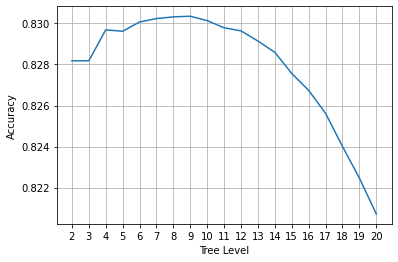

In [0]:
acc = []
for i in range(2, 21): #range change according to reccord
    tr = DecisionTreeClassifier(random_state=42, max_depth=i)
    tr.fit(X_train, y_train)
    acc.append(accuracy_score(y_test,tr.predict(X_test)))

plt.xticks(range(0,21))
plt.plot(range(2, 21), acc)
plt.ylabel('Accuracy')
plt.xlabel('Tree Level')
plt.grid(True)
plt.show()

In [0]:
tr2 = DecisionTreeClassifier(random_state=42, max_depth=9)
tr2.fit(X_train, y_train)
print(classification_report(y_test, tr2.predict(X_test)))

              precision    recall  f1-score   support

           0       0.78      0.66      0.72    105656
           1       0.85      0.91      0.88    218341

    accuracy                           0.83    323997
   macro avg       0.82      0.79      0.80    323997
weighted avg       0.83      0.83      0.83    323997



Out[18]: [Text(170.4994879756871, 206.56799999999998, 'X[0] <= 0.137\ngini = 0.44\nsamples = 1295988\nvalue = [422625, 873363]'),
 Text(86.62529730443974, 184.824, 'X[0] <= 0.032\ngini = 0.359\nsamples = 376769\nvalue = [288394, 88375]'),
 Text(44.084064482029596, 163.07999999999998, 'X[0] <= -0.075\ngini = 0.203\nsamples = 220520\nvalue = [195244, 25276]'),
 Text(21.654941860465115, 141.336, 'X[0] <= -0.2\ngini = 0.116\nsamples = 122593\nvalue = [115006, 7587]'),
 Text(10.750052854122622, 119.592, 'X[0] <= -0.303\ngini = 0.074\nsamples = 58440\nvalue = [56207, 2233]'),
 Text(5.662579281183932, 97.848, 'X[1] <= 0.896\ngini = 0.059\nsamples = 32370\nvalue = [31392, 978]'),
 Text(2.831289640591966, 76.10399999999998, 'X[0] <= -0.699\ngini = 0.048\nsamples = 27009\nvalue = [26340, 669]'),
 Text(1.415644820295983, 54.360000000000014, 'X[1] <= 0.752\ngini = 0.094\nsamples = 1579\nvalue = [1501, 78]'),
 Text(0.7078224101479915, 32.615999999999985, 'X[1] <= 0.745\ngini = 0.161\nsamples = 769\

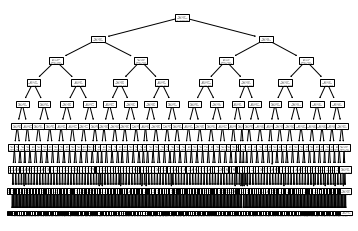

In [0]:
from sklearn import tree
tree.plot_tree(tr2)

### testing

In [0]:
import random
Xyinput = []
for i in range(15):
    temp=[]
    p = random.uniform(-1,1)
    temp.append(p)
    s = random.uniform(0,1)
    temp.append(s)
    Xyinput.append(temp)
mat = np.matrix(Xyinput)

In [0]:
yhat = lr.predict(mat)
for i in range(15):
    ans = ''
    if yhat[i] == 1:
        ans = 'Good Review'
    else:
        ans = 'Bad Review'
    print(mat[i], ans)

[[0.93118329 0.42661818]] Good Review
[[0.94081758 0.93919661]] Good Review
[[0.15579562 0.22787332]] Bad Review
[[0.33802233 0.76614313]] Good Review
[[-0.45779534  0.96195124]] Bad Review
[[0.15469431 0.31214769]] Bad Review
[[0.13177203 0.13362948]] Bad Review
[[-0.18699244  0.48115366]] Bad Review
[[-0.293245    0.11900158]] Bad Review
[[-0.78782131  0.95261693]] Bad Review
[[-0.29442109  0.94246653]] Bad Review
[[-0.20840013  0.8792203 ]] Bad Review
[[-0.30281335  0.97759043]] Bad Review
[[-0.29242147  0.23101087]] Bad Review
[[-0.09146241  0.68195592]] Bad Review


|          |           |          |
|:--------:|:---------:|:--------:|
|Polarity|Subjectivity|Prediction|
|0.99151449| 0.83368956 |  Good Review  |
|-0.93938112| 0.17225869|  Bad Review |
|0.3607222|0.94344842|Good Review|
|0.15489641|0.33225373|Bad Review|

Polarity lies in the range of [-1,1] where 

1 = positive statement 

-1 = negative statement. 

Subjectivity is a float which lies in the range of [0,1]. Subjectivity quantifies the amount of personal opinion and factual information contained in the text. 

1 = personal opinion

0 = factual information

## Association Rule

In [0]:
df = businessDFClean.select('state').where(businessDFClean.categories.like('%Restaurants%')).groupby("state").agg(count("state").alias("numState")).orderBy(["numState"],ascending=[0,1])
df.display()

state numState MA 10550 FL 7705 BC 7506 OR 7390 GA 6139 TX 5442 OH 4376 CO 865 WA 773 Austin 3 Orlando 3 Boston 2 Atlanta 2 Framingham 1 MN 1 Westwood 1 VA 1 NH 1 KS 1 Hingham 1 WY 1 Cocoa 1 Cambridge 1 Burlington 1 ABE 1 KY 1 Columbus 1 Altamonte Springs 1

### British Columbia (BC) 4-5 Stars

In [0]:
BCDF = associationDF.filter(associationDF['state'].isin('BC'))

In [0]:
BCgoodDF = BCDF.filter(BCDF['review_stars']>3)
BCgoodDF.count()

Out[23]: 62976

In [0]:
BCgoodPDF = BCgoodDF.toPandas()

In [0]:
BCgoodPDF1 = BCgoodPDF.apply(lambda row: nltk.word_tokenize(row['lemmatized']), axis=1)
te = TransactionEncoder()
te_ary = te.fit(BCgoodPDF1).transform(BCgoodPDF1)
BCgoodPDF2 = pd.DataFrame(te_ary, columns=te.columns_)

In [0]:
frequent_itemsets_BCgood = apriori(BCgoodPDF2, min_support=0.1, use_colnames=True)
print(frequent_itemsets_BCgood.sort_values("support", ascending=False))

     support          itemsets
16  0.378874            (good)
26  0.367553           (place)
12  0.355802            (food)
17  0.329808           (great)
31  0.300543         (service)
34  0.262878            (time)
18  0.218020            (like)
28  0.203395          (really)
15  0.197154             (get)
7   0.195122       (delicious)
6   0.179926      (definitely)
37  0.176210            (well)
30  0.173860      (restaurant)
14  0.172605        (friendly)
2   0.170224            (best)
23  0.168429            (nice)
35  0.164809             (try)
38  0.162602      (good, food)
45  0.159251     (good, place)
40  0.150788     (food, place)
32  0.150327           (staff)
41  0.149867   (service, food)
29  0.149517       (recommend)
21  0.149231            (love)
25  0.147596         (ordered)
1   0.143991         (amazing)
27  0.139291           (price)
39  0.137910     (great, food)
36  0.136639       (vancouver)
49  0.130558    (great, place)
47  0.130335   (good, service)
50  0.12

In [0]:
print(association_rules(frequent_itemsets_BCgood, metric="confidence", min_threshold=0.3)) 

   antecedents consequents  antecedent support  consequent support   support  \
0       (good)      (food)            0.378874            0.355802  0.162602   
1       (food)      (good)            0.355802            0.378874  0.162602   
2      (great)      (food)            0.329808            0.355802  0.137910   
3       (food)     (great)            0.355802            0.329808  0.137910   
4       (food)     (place)            0.355802            0.367553  0.150788   
5      (place)      (food)            0.367553            0.355802  0.150788   
6    (service)      (food)            0.300543            0.355802  0.149867   
7       (food)   (service)            0.355802            0.300543  0.149867   
8       (time)      (food)            0.262878            0.355802  0.102833   
9       (good)     (great)            0.378874            0.329808  0.117775   
10     (great)      (good)            0.329808            0.378874  0.117775   
11      (like)      (good)            0.

### British Columbia (BC) 1-2 Stars

In [0]:
BCbadDF = BCDF.filter(BCDF['review_stars']<2)
BCbadDF.count()

Out[28]: 14430

In [0]:
BCbadPDF = BCbadDF.toPandas()

In [0]:
BCbadPDF1 = BCbadPDF.apply(lambda row: nltk.word_tokenize(row['lemmatized']), axis=1)
te = TransactionEncoder()
te_ary = te.fit(BCbadPDF1).transform(BCbadPDF1)
BCbadPDF2 = pd.DataFrame(te_ary, columns=te.columns_)

In [0]:
frequent_itemsets_BCbad = apriori(BCbadPDF2, min_support=0.1, use_colnames=True)
print(frequent_itemsets_BCbad.sort_values("support", ascending=False))

     support             itemsets
35  0.348164            (service)
40  0.328067               (time)
12  0.291268               (food)
28  0.275468              (place)
20  0.268399               (like)
13  0.261677                (get)
8   0.244491               (dont)
6   0.229868           (customer)
24  0.217810              (never)
33  0.203534               (said)
25  0.188981              (order)
1   0.188496              (asked)
41  0.187249               (told)
16  0.186556               (good)
26  0.180042            (ordered)
10  0.154401         (experience)
30  0.152460         (restaurant)
48  0.149480  (customer, service)
27  0.148371             (people)
11  0.144352              (first)
18  0.143867               (know)
3   0.143174                (bad)
39  0.140263               (take)
7   0.139362                (day)
36  0.138669              (staff)
56  0.135828      (service, time)
14  0.135412               (give)
9   0.134026               (ever)
15  0.133125  

In [0]:
print(association_rules(frequent_itemsets_BCbad, metric="confidence", min_threshold=0.3)) 

   antecedents consequents  antecedent support  consequent support   support  \
0   (customer)   (service)            0.229868            0.348164  0.149480   
1    (service)  (customer)            0.348164            0.229868  0.149480   
2       (time)      (dont)            0.328067            0.244491  0.101594   
3       (dont)      (time)            0.244491            0.328067  0.101594   
4       (food)     (place)            0.291268            0.275468  0.104366   
5      (place)      (food)            0.275468            0.291268  0.104366   
6    (service)      (food)            0.348164            0.291268  0.123562   
7       (food)   (service)            0.291268            0.348164  0.123562   
8    (service)       (get)            0.348164            0.261677  0.109494   
9        (get)   (service)            0.261677            0.348164  0.109494   
10       (get)      (time)            0.261677            0.328067  0.118018   
11      (time)       (get)            0.

### Oregon (OR) 4 stars

In [0]:
ORDF = associationDF.filter(associationDF['state'].isin('OR'))

In [0]:
ORgoodDF = ORDF.filter(BCDF['review_stars'] == 4)
ORgoodDF.count()

Out[34]: 35495

In [0]:
ORgoodPDF = ORgoodDF.toPandas()

In [0]:
ORgoodPDF1 = ORgoodPDF.apply(lambda row: nltk.word_tokenize(row['lemmatized']), axis=1)
te = TransactionEncoder()
te_ary = te.fit(ORgoodPDF1).transform(ORgoodPDF1)
ORgoodPDF2 = pd.DataFrame(te_ary, columns=te.columns_)

In [0]:
frequent_itemsets_ORgood = apriori(ORgoodPDF2, min_support=0.1, use_colnames=True)
print(frequent_itemsets_ORgood.sort_values("support", ascending=False))

     support          itemsets
13  0.459952            (good)
10  0.367066            (food)
23  0.349627           (place)
14  0.348584           (great)
34  0.262685            (time)
15  0.248767            (like)
29  0.243133         (service)
12  0.226849             (get)
27  0.224229          (really)
37  0.199606      (good, food)
20  0.193492            (nice)
47  0.180335     (good, place)
16  0.167348          (little)
36  0.165629            (well)
5   0.162333       (delicious)
11  0.159910        (friendly)
4   0.158445      (definitely)
44  0.150049     (good, great)
35  0.148387             (try)
21  0.147260           (order)
22  0.146922         (ordered)
38  0.145570     (great, food)
40  0.144330     (food, place)
25  0.142724          (pretty)
51  0.135906    (great, place)
24  0.134780        (portland)
45  0.132357      (like, good)
18  0.131765            (love)
48  0.131624    (good, really)
50  0.131427      (good, time)
26  0.130300           (price)
49  0.12

In [0]:
print(association_rules(frequent_itemsets_ORgood, metric="confidence", min_threshold=0.3)) 

   antecedents consequents  antecedent support  consequent support   support  \
0       (good)      (food)            0.459952            0.367066  0.199606   
1       (food)      (good)            0.367066            0.459952  0.199606   
2      (great)      (food)            0.348584            0.367066  0.145570   
3       (food)     (great)            0.367066            0.348584  0.145570   
4       (like)      (food)            0.248767            0.367066  0.100944   
5       (food)     (place)            0.367066            0.349627  0.144330   
6      (place)      (food)            0.349627            0.367066  0.144330   
7    (service)      (food)            0.243133            0.367066  0.118411   
8       (food)   (service)            0.367066            0.243133  0.118411   
9       (time)      (food)            0.262685            0.367066  0.103592   
10       (get)      (good)            0.226849            0.459952  0.113847   
11      (good)     (great)            0.

### Oregon (OR) 1-2 stars

In [0]:
ORbadDF = ORDF.filter(ORDF['review_stars']<2)
ORbadDF.count()

Out[39]: 40200

In [0]:
ORbadPDF = ORbadDF.toPandas()

In [0]:
ORbadPDF1 = ORbadPDF.apply(lambda row: nltk.word_tokenize(row['lemmatized']), axis=1)
te = TransactionEncoder()
te_ary = te.fit(ORbadPDF1).transform(ORbadPDF1)
ORbadPDF2 = pd.DataFrame(te_ary, columns=te.columns_)

In [0]:
frequent_itemsets_ORbad = apriori(ORbadPDF2, min_support=0.1, use_colnames=True)
print(frequent_itemsets_ORbad.sort_values("support", ascending=False))

     support          itemsets
41  0.357189            (time)
13  0.317537             (get)
37  0.304751         (service)
20  0.268731            (like)
29  0.266219           (place)
..       ...               ...
56  0.102861      (get, never)
52  0.102313  (customer, time)
60  0.101468       (get, told)
25  0.101393             (new)
32  0.100572           (right)

[67 rows x 2 columns]


In [0]:
print(association_rules(frequent_itemsets_ORbad, metric="confidence", min_threshold=0.3)) 

   antecedents consequents  antecedent support  consequent support   support  \
0   (customer)   (service)            0.231866            0.304751  0.154627   
1    (service)  (customer)            0.304751            0.231866  0.154627   
2   (customer)      (time)            0.231866            0.357189  0.102313   
3        (get)      (dont)            0.317537            0.250721  0.106940   
4       (dont)       (get)            0.250721            0.317537  0.106940   
5       (time)      (dont)            0.357189            0.250721  0.113109   
6       (dont)      (time)            0.250721            0.357189  0.113109   
7       (like)       (get)            0.268731            0.317537  0.107861   
8        (get)      (like)            0.317537            0.268731  0.107861   
9        (get)     (never)            0.317537            0.249652  0.102861   
10     (never)       (get)            0.249652            0.317537  0.102861   
11      (said)       (get)            0.

## Word Cloud

In [0]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [0]:
associationDF.createOrReplaceTempView("wordCloudSQL")

In [0]:
%sql
create temp view review_words as
select lemmatized, posexplode(split(lemmatized, ' ')) as (position, word)
from wordCloudSQL
where polarity > 0.3 and review_stars > 3;

In [0]:
%sql
create temp view review_top_50 as
select word, count(1) as `count`
from review_words
where word not in ('not', 'dont', 'food', 'great', 'like', 'get', 'really', 'try', 'nice', 'always', 'everything', 'much',  'eat', 'friend', 'thing', 'one', 'two', 'better', 'favorite', 'lot', 'say', 'ever', 'spot', 'way', 'know', 'still', 'right', 'want', 'sure', 'wasnt', 'going', 'give', 'bit', 'hour', '2', 'cant', 'never', 'definitely', 'many', '')
group by word
order by `count` desc
limit 50;

In [0]:
%sql
create temp view review_word_cloud as
select array_join(collect_list(word), ' ') as `text`
from (
  select word
  from review_words
  where word in (select word from review_top_50))

In [0]:
review_word_cloud_table = spark.sql('''
 select array_join(collect_list(word), ' ') as `text`
 from (
    select word
    from review_words
    where word in (select word from review_top_50)
 )
''')

In [0]:
review_word_cloud_table.createOrReplaceTempView("review_word_cloud_table")

In [0]:
# Create a variable text that contains our text for the word cloud
# Change the table/view you are selecting from depending on whether you created a table or not
text = spark.sql('''
  select text from review_word_cloud_table
''')


Out[49]: <matplotlib.image.AxesImage at 0x7f3e496430d0>

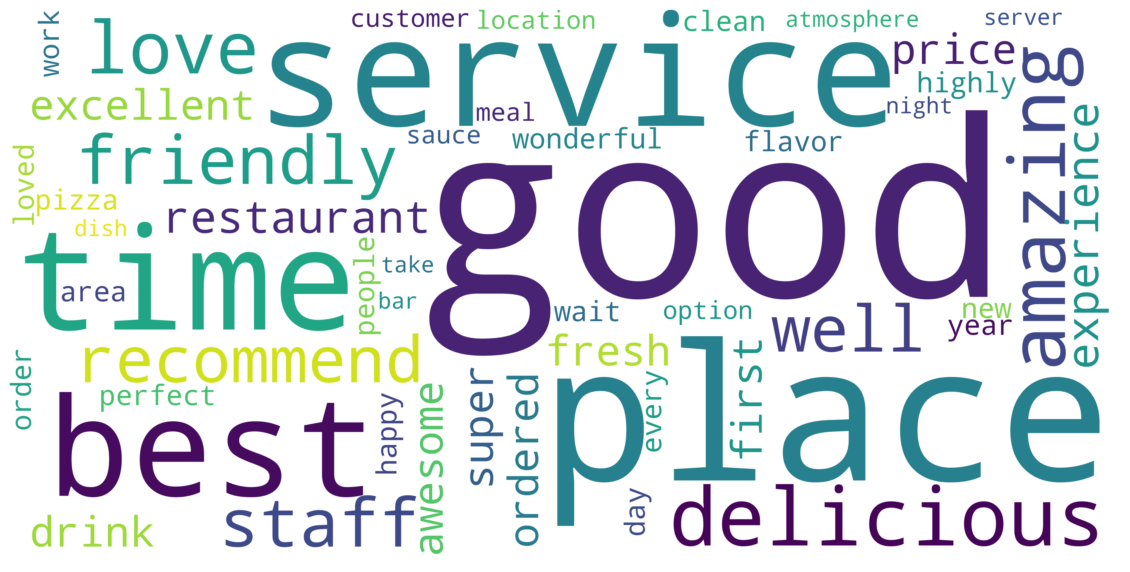

In [0]:
# In python we can also filter stop words 
my_stopwords = set(STOPWORDS)
#my_stopwords.add("und")

# Generate a word cloud image
wordcloud = WordCloud(scale=10, collocations=False, background_color="white", random_state=1 # Make sure the output is always the same for the same input
             ).generate(text.take(1)[0].text)

# Display the generated image the matplotlib way:
plt.figure(figsize=(20,20))
plt.axis("off")
plt.imshow(wordcloud, interpolation='bilinear')

In [0]:
%sql
create temp view review_words_bad as
select lemmatized, posexplode(split(lemmatized, ' ')) as (position, word)
from wordCloudSQL
where polarity < -0.3 and review_stars < 3;

In [0]:
%sql
create temp view review_bottom_50 as
select word, count(1) as `count`
from review_words_bad
where word not in ('', 'never', 'horrible', 'order', 'terrible', 'get', 'ever', 'done', 'like', 'bad', 'chicken', 'give', 'ordered', 'disappointed', 'disgusting', 'want', 'call', 'wrong')
group by word
order by `count` desc
limit 50;

In [0]:
df1 = spark.sql('''
 select array_join(collect_list(word), ' ') as `text`
 from (
    select word
    from review_words_bad
    where word in (select word from review_bottom_50)
 )
''')

df1.createOrReplaceTempView("review_word_bad_cloud_table")

badtext = spark.sql('''
  select text from review_word_bad_cloud_table
''')

Out[51]: <matplotlib.image.AxesImage at 0x7f3e49210460>

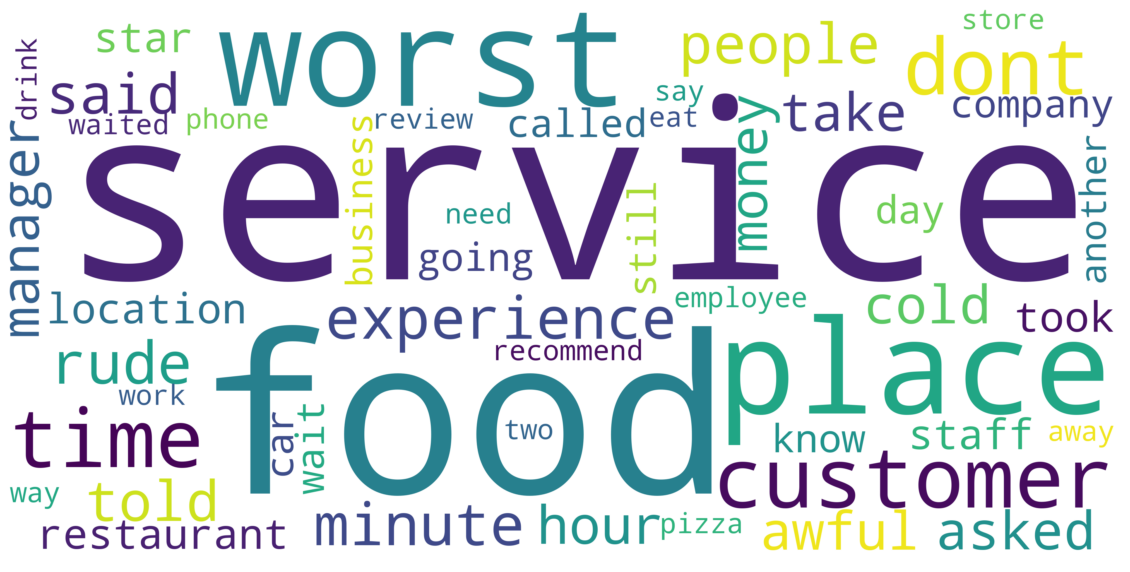

In [0]:
# In python we can also filter stop words 
my_stopwords = set(STOPWORDS)
#my_stopwords.add("und")

# Generate a word cloud image
badwordcloud = WordCloud(scale=10, collocations=False, background_color="white", random_state=1 # Make sure the output is always the same for the same input
             ).generate(badtext.take(1)[0].text)

# Display the generated image the matplotlib way:
plt.figure(figsize=(20,20))
plt.axis("off")
plt.imshow(badwordcloud, interpolation='bilinear')

# Xun Yin

### Each overall ratings from 1 - 5 for businesses open and closed
In this visualisation, we can see that for restaurants that are still open, the overall ratings are scaled to the most right while the restaurants that is closed already, the overall ratings are at around 3.5 which has a lower rating as compared to restaurants that is still open. Thus, the restaurants that are still open perfoming better and ratings mostly are at around 4 and above.

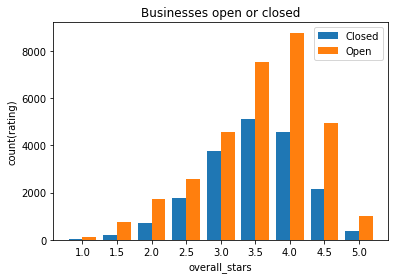

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

ratings0DF = closed_stars_rangeDF.toPandas()
ratings1DF = open_stars_rangeDF.toPandas()

plt.figure()

stars = ratings0DF.overall_stars
closed = ratings0DF.num_of_ratings
open = ratings1DF.num_of_ratings

x_axis = np.arange(len(stars))

plt.bar(x_axis -0.2, closed, width=0.4, label = 'Closed')
plt.bar(x_axis +0.2, open, width=0.4, label = 'Open')

plt.xticks(x_axis, stars)

plt.title("Businesses open or closed")
plt.xlabel("overall_stars")
plt.ylabel("count(rating)")
plt.legend()
plt.show()

### Top 5 states that have the number of businesses closed or still open
This visualisation compares those closed and open restaurants in the states and to see which top 5 states have higher number of restaurants closed or open. The first one is the number of restaurants closed in the states and the second one is the number of restaurants still open in the states.
From this we can see that Massachusetts has the highest number of restaurants open and closed. That means this might be a popular state where many restaurants choose to open here as to attract more people. However, eventhough MA has the highest number of restaurants open but it also has the highest number of restaurants closed which means the restaurants in MA are quite competitive as compared to other states. Therefore, restaurants in MA must maintain there high level of food and services so that restaurants will continue to do better. 
The not recommend state will be in Oregon as it has the 2nd highest number of restaurants closed. There are a total of 7402 restaurants in Oregon but out of all, there are 3170 restaurants closed and 4232 restaurants still open in this state. The percentage ratio of closed is around 40% which consider a high risk state that the business will close. Thus, not recommend to start a business restaurants in Oregon.
Well, the recommended state is Florida where it has the 2nd highest number of restaurants still open. There are total number of 7713 restaurants here while 5400 restaurants still open which has a lower risk of close as compare to in other states.

In [0]:
closed_state_DF.display()
open_state_DF.display()

state num_of_business MA 4096 OR 3170 BC 2778 FL 2313 TX 2290

state num_of_business MA 6465 FL 5400 BC 4729 OR 4232 GA 3936

### Number of reviews count by months in 2019 and 2020
In this visualisation, I count the reviews of the restaurants by month in 2019 and 2020. We can see that the number of reviews in 2019 is much higher than the number of reviews in 2020. In 2020, there is an obvious big descreasing number of reviews in March, April. The cause might be because of the hit of COVID-19 thus, many people did not go out or dine in in the restaurants so that's why lesser reviews from the customers. Well, after April, we can see that it slowly increases but still not as good as the customers leave reviews in 2019. Hence, my recommendation to this especially in the covid pandemic, the restaurants can provide or can improve on their food delivery service so that when customers are at home they can still order the food from their restaurants to deliver to their house. By doing this, the restaurants will not suffer from it and they can still continue their business even in this pandemic.

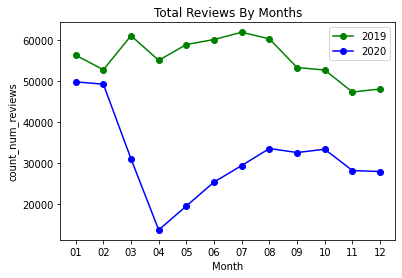

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

reviews2019DF = review_2019DF.toPandas()
reviews2020DF = review_2020DF.toPandas()

# number of reviews
Y2019 = reviews2019DF.count_num_reviews
Y2020 = reviews2020DF.count_num_reviews
month = reviews2020DF.Month

# plot two lines
plt.plot(month, Y2019, 'o-g')
plt.plot(month, Y2020, 'o-b')
# set axis titles
plt.xlabel("Month")
plt.ylabel("count_num_reviews")
# set chart title
plt.title("Total Reviews By Months")
# legend
plt.legend(['2019', '2020'])
plt.show()

### The average star rating of both closed and still open restaurant
This 2 graphs show the average star rating of 2 restaurants which one is closed and has the highest number of reviews in the restuarants that have closed, and another one is still open and has the highest number of reviews in the restuarants that is still open. Top is closed restaurant, below is open restaurant.
From the graphs, we can see that the average rating for the business that closed has descreased throughout the year while the restaurant that is still open, their average star rating has increased throughout the year. Hence, from this, we can see that why the business will close and why the business is still open has it reason. Therefore, a good restaurant must ensure they maintain or get better star rating so that their business will face the risk of closing down.

In [0]:
closed_avg_stars.display()
open_avg_stars.display()

business_id review_stars year zioLxtBc9THNS2TOn9xW1w 4 2020-01-01 zioLxtBc9THNS2TOn9xW1w 1 2020-01-01 zioLxtBc9THNS2TOn9xW1w 4 2020-01-01 zioLxtBc9THNS2TOn9xW1w 5 2020-01-01 zioLxtBc9THNS2TOn9xW1w 4 2020-01-01 zioLxtBc9THNS2TOn9xW1w 2 2020-01-01 zioLxtBc9THNS2TOn9xW1w 5 2020-01-01 zioLxtBc9THNS2TOn9xW1w 4 2020-01-01 zioLxtBc9THNS2TOn9xW1w 3 2020-01-01 zioLxtBc9THNS2TOn9xW1w 5 2020-01-01 zioLxtBc9THNS2TOn9xW1w 5 2020-01-01 zioLxtBc9THNS2TOn9xW1w 3 2020-01-01 zioLxtBc9THNS2TOn9xW1w 5 2020-01-01 zioLxtBc9THNS2TOn9xW1w 2 2020-01-01 zioLxtBc9THNS2TOn9xW1w 4 2020-01-01 zioLxtBc9THNS2TOn9xW1w 1 2020-01-01 zioLxtBc9THNS2TOn9xW1w 5 2020-01-01 zioLxtBc9THNS2TOn9xW1w 5 2020-01-01 zioLxtBc9THNS2TOn9xW1w 5 2020-01-01 zioLxtBc9THNS2TOn9xW1w 4 2020-01-01 zioLxtBc9THNS2TOn9xW1w 5 2020-01-01 zioLxtBc9THNS2TOn9xW1w 5 2020-01-01 zioLxtBc9THNS2TOn9xW1w 4 2020-01-01 zioLxtBc9THNS2TOn9xW1w 3 2020-01-01 zioLxtBc9THNS2TOn9xW1w 5 2020-01-01 zioLxtBc9THNS2TOn9xW1w 4 2020-01-01 zioLxtBc9THNS2TOn9xW1w 4 2020-01-01 zioLxtBc9THNS2TOn9xW1w 5 2020-01-01 zioLxtBc9THNS2TOn9xW1w 3 2020-01-01 zioLxtBc9THNS2TOn9xW1w 5 2020-01-01 zioLxtBc9THNS2TOn9xW1w 1 2020-01-01 zioLxtBc9THNS2TOn9xW1w 4 2020-01-01 zioLxtBc9THNS2TOn9xW1w 2 2020-01-01 zioLxtBc9THNS2TOn9xW1w 5 2020-01-01 zioLxtBc9THNS2TOn9xW1w 5 2020-01-01 zioLxtBc9THNS2TOn9xW1w 4 2020-01-01 zioLxtBc9THNS2TOn9xW1w 5 2020-01-01 zioLxtBc9THNS2TOn9xW1w 5 2020-01-01 zioLxtBc9THNS2TOn9xW1w 2 2020-01-01 zioLxtBc9THNS2TOn9xW1w 5 2020-01-01 zioLxtBc9THNS2TOn9xW1w 3 2020-01-01 zioLxtBc9THNS2TOn9xW1w 1 2020-01-01 zioLxtBc9THNS2TOn9xW1w 4 2020-01-01 zioLxtBc9THNS2TOn9xW1w 5 2020-01-01 zioLxtBc9THNS2TOn9xW1w 4 2020-01-01 zioLxtBc9THNS2TOn9xW1w 5 2020-01-01 zioLxtBc9THNS2TOn9xW1w 5 2020-01-01 zioLxtBc9THNS2TOn9xW1w 5 2020-01-01 zioLxtBc9THNS2TOn9xW1w 3 2020-01-01 zioLxtBc9THNS2TOn9xW1w 5 2020-01-01 zioLxtBc9THNS2TOn9xW1w 1 2020-01-01 zioLxtBc9THNS2TOn9xW1w 1 2020-01-01 zioLxtBc9THNS2TOn9xW1w 3 2020-01-01 zioLxtBc9THNS2TOn9xW1w 3 2020-01-01 zioLxtBc9THNS2TOn9xW1w 4 2020-01-01 zioLxtBc9THNS2TOn9xW1w 4 2020-01-01 zioLxtBc9THNS2TOn9xW1w 4 2020-01-01 zioLxtBc9THNS2TOn9xW1w 3 2020-01-01 zioLxtBc9THNS2TOn9xW1w 2 2020-01-01 zioLxtBc9THNS2TOn9xW1w 5 2020-01-01 zioLxtBc9THNS2TOn9xW1w 4 2020-01-01 zioLxtBc9THNS2TOn9xW1w 5 2020-01-01 zioLxtBc9THNS2TOn9xW1w 3 2020-01-01 zioLxtBc9THNS2TOn9xW1w 4 2020-01-01 zioLxtBc9THNS2TOn9xW1w 3 2020-01-01 zioLxtBc9THNS2TOn9xW1w 3 2020-01-01 zioLxtBc9THNS2TOn9xW1w 4 2020-01-01 zioLxtBc9THNS2TOn9xW1w 5 2020-01-01 zioLxtBc9THNS2TOn9xW1w 3 2020-01-01 zioLxtBc9THNS2TOn9xW1w 5 2020-01-01 zioLxtBc9THNS2TOn9xW1w 2 2020-01-01 zioLxtBc9THNS2TOn9xW1w 3 2020-01-01 zioLxtBc9THNS2TOn9xW1w 1 2020-01-01 zioLxtBc9THNS2TOn9xW1w 5 2020-01-01 zioLxtBc9THNS2TOn9xW1w 3 2020-01-01 zioLxtBc9THNS2TOn9xW1w 2 2020-01-01 zioLxtBc9THNS2TOn9xW1w 4 2019-01-01 zioLxtBc9THNS2TOn9xW1w 5 2019-01-01 zioLxtBc9THNS2TOn9xW1w 3 2019-01-01 zioLxtBc9THNS2TOn9xW1w 5 2019-01-01 zioLxtBc9THNS2TOn9xW1w 5 2019-01-01 zioLxtBc9THNS2TOn9xW1w 3 2019-01-01 zioLxtBc9THNS2TOn9xW1w 5 2019-01-01 zioLxtBc9THNS2TOn9xW1w 3 2019-01-01 zioLxtBc9THNS2TOn9xW1w 2 2019-01-01 zioLxtBc9THNS2TOn9xW1w 5 2019-01-01 zioLxtBc9THNS2TOn9xW1w 5 2019-01-01 zioLxtBc9THNS2TOn9xW1w 5 2019-01-01 zioLxtBc9THNS2TOn9xW1w 5 2019-01-01 zioLxtBc9THNS2TOn9xW1w 2 2019-01-01 zioLxtBc9THNS2TOn9xW1w 5 2019-01-01 zioLxtBc9THNS2TOn9xW1w 2 2019-01-01 zioLxtBc9THNS2TOn9xW1w 5 2019-01-01 zioLxtBc9THNS2TOn9xW1w 4 2019-01-01 zioLxtBc9THNS2TOn9xW1w 2 2019-01-01 zioLxtBc9THNS2TOn9xW1w 3 2019-01-01 zioLxtBc9THNS2TOn9xW1w 3 2019-01-01 zioLxtBc9THNS2TOn9xW1w 3 2019-01-01 zioLxtBc9THNS2TOn9xW1w 2 2019-01-01 zioLxtBc9THNS2TOn9xW1w 5 2019-01-01 zioLxtBc9THNS2TOn9xW1w 3 2019-01-01 zioLxtBc9THNS2TOn9xW1w 4 2019-01-01 zioLxtBc9THNS2TOn9xW1w 5 2019-01-01 zioLxtBc9THNS2TOn9xW1w 3 2019-01-01 zioLxtBc9THNS2TOn9xW1w 3 2019-01-01 zioLxtBc9THNS2TOn9xW1w 3 2019-01-01 zioLxtBc9THNS2TOn9xW1w 3 2019-01-01 zioLxtBc9THNS2TOn9xW1w 2 2019-01-01 zioLxtBc9THNS2TOn9xW1w 3 2019-01-01 zioLxtBc9THNS2TOn9xW1w 4 2019-01-01 zioLxtBc9T

business_id review_stars year 4CxF8c3MB7VAdY8zFb2cZQ 5 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 5 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 4 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 4 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 4 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 5 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 4 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 5 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 5 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 3 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 4 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 5 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 4 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 5 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 2 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 2 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 4 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 4 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 2 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 5 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 5 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 3 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 5 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 3 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 5 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 4 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 5 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 4 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 5 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 3 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 5 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 5 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 5 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 4 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 3 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 4 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 3 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 5 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 4 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 4 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 4 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 4 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 5 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 5 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 3 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 5 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 2 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 4 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 4 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 4 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 5 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 1 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 3 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 4 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 5 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 5 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 5 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 5 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 1 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 5 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 5 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 4 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 5 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 5 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 3 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 5 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 5 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 4 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 3 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 2 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 4 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 4 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 2 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 5 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 5 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 5 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 5 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 5 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 3 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 4 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 3 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 4 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 5 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 1 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 1 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 1 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 3 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 5 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 3 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 5 2020-01-01 4CxF8c3MB7VAdY8zFb2cZQ 4 2019-01-01 4CxF8c3MB7VAdY8zFb2cZQ 5 2019-01-01 4CxF8c3MB7VAdY8zFb2cZQ 5 2019-01-01 4CxF8c3MB7VAdY8zFb2cZQ 4 2019-01-01 4CxF8c3MB7VAdY8zFb2cZQ 3 2019-01-01 4CxF8c3MB7VAdY8zFb2cZQ 2 2019-01-01 4CxF8c3MB7VAdY8zFb2cZQ 5 2019-01-01 4CxF8c3MB7VAdY8zFb2cZQ 1 2019-01-01 4CxF8c3MB7VAdY8zFb2cZQ 3 2019-01-01 4CxF8c3MB7VAdY8zFb2cZQ 4 2019-01-01 4CxF8c3MB7VAdY8zFb2cZQ 5 2019-01-01 4CxF8c3MB7VAdY8zFb2cZQ 4 2019-01-01 4CxF8c3MB7VAdY8zFb2cZQ 4 2019-01-01 4CxF8c3MB7VAdY8zFb2cZQ 5 2019-01-01 4CxF8c3MB7VAdY8zFb2cZQ 1 2019-01-01 4CxF8c3MB7VAdY8zFb2cZQ 4 2019-01-01 4CxF8c3MB7VAdY8zFb2cZQ 5 2019-01-01 4CxF8c3MB7VAdY8zFb2cZQ 4 2019-01-01 4CxF8c3MB7VAdY8zFb2cZQ 4 2019-01-01 4CxF8c3MB7VAdY8zFb2cZQ 3 2019-01-01 4CxF8c3MB7

### Total number of count review stars by year 2019 and 2020 for the business which has the highest reviews counts but was closed
This visualisation shows the restaurant that has highest number of reviews but was closed. Number of count review stars shows how good the business is by adding up all the stars by month. In 2919, the count of review stars for restaurant was still better than in 2020 but was not vert stable. While there was an extreme big descreasing in 2020 and even the number of count stars did not increase throughout the year. In above we say that we recommend restaurants to have food delivery service but this restaurant actually provided restaurant delivery however the business still did not become better and even closed after that. Thus, in the next visualisation, we will analyse what customers said the most in their reviews.

In [0]:
num_reviews_2019.display()
num_reviews_2020.display()

Month count_num_reviews 01 57 02 33 03 49 04 48 05 41 06 42 07 51 08 62 09 57 10 42 11 39 12 42

Month count_num_reviews 01 35 02 29 03 12 04 5 05 1 07 1 08 4 09 3 10 4 11 1 12 1

### Word count for the restaurant
These are the count of words from the reviews where customers leave their reviews for this restaurants. I picked the above restaurant that has the highest number of reviews to see what the customers have mentioned in their reviews so that other restaurants will know which areas the customers are looking for to give good reviews so that the restaurant will not be closed.

In [0]:
wordcountDF.display()

word count the 1277 and 836 a 572 to 546 i 500 was 469 of 396 is 320 it 300 we 285 in 284 with 261 pok 217 this 198 but 195 for 193 so 184 wings 176 that 176 were 168 my 167 on 159 you 155 had 147 are 144 food 135 they 133 131 as 121 be 116 sauce 112 fish 105 chicken 101 thai 99 not 91 have 91 at 89 good 87 would 86 their 84 like 84 very 84 our 82 place 82 get 77 it's 75 if 75 all 73 pork 72 just 72 great 70 which 70 some 68 spicy 68 definitely 68 really 67 here 66 about 66 when 64 go 64 also 62 rice 60 love 59 out 59 ordered 59 from 56 up 56 eat 55 worth 55 wait 55 wings. 55 dishes 53 back 53 what 53 an 53 try 53 one 52 me 52 papaya 51 more 50 can 50 sticky 50 - 49 got 48 portland 47 because 46 there 46 best 45 restaurant 45 order 44 been 44 time 42 come 41 little 41 other 40 i've 40 wings, 40 everything 39 delicious 39 us 38 salad 38 it. 38 well 38 or 38 amazing 37 first 37 recommend 36 i'm 35 will 34 curry 34 don't 34 how 34 can't 34 your 34 dish 33 super 33 vietnamese 33 made 33 even 32 belly 32 came 32 say 31 loved 31 service 31 went 31 delicious. 30 favorite 30 only 30 still 29 always 29 good. 29 portland. 28 around 28 has 28 he 28 street 28 did 27 bit 27 coconut 27 them 27 menu 27 could 26 tried 26 taste 26 than 26 nice 26 highly 25 must 25 too 25 5 25 didn't 25 know 25 flavors 24 by 24 rice. 24 make 24 every 24 two 23 who 23 flavor 23 she 23 sweet 23 right 23 pretty 23 down 22 next 22 think 22 visiting 22 famous 21 friends 21 much 21 you're 21 well. 21 since 21 ever 21 food. 20 ike's 20 visit 20 after 20 long 20 wun 20 never 20 authentic 20 many 20 family 19 times 19 absolutely 19 while 19 

the 19 no 19 way 19 served 19 most 19 said 18 wasn't 18 side 18 those 17 perfect 17 asian 17 both 17 glass 17 food, 17 each 17 people 17 any 17 off 17 want 17 do 17 before 17 eating 17 day 16 wing 16 op 16 place. 16 glad 16 "i 16 fried 16 hang 16 experience 16 2 16 stop 16 server 15 here. 15 spicy, 15 these 15 thing 15 kung 15 again 15 took 15 atmosphere 15 noodle 15 meal 15 pok. 15 

i 15 over 15 half 15 wait. 15 noodles 15 enjoyed 15 sure 14 waitress 14 thailand 14 such 14 salad, 14 into 14 spot 14 friendly 14 places 14 leh 14 something 14 dining 14 home 14 

we 14 his 14 good, 14 recommended 14 staff 13 amazing. 13 table 13 take 13 enough 13 without 13 different 13 probably 13 things 13 getting 13 muu 13 lot 13 flavorful 13 it! 13 unique 13 being 13 gave 13 few 12 sen 12 dish. 12 boar 12 hype 12 whiskey 12 delicious! 12 bite 12 everyone 12 seated 12 better 12 small 12 savory 12 another 12 then 12 trip 12 meat 11 perfectly 11 good! 11 ribs 11 drinks 11 khao 11 water 11 old 11 night 11 makes 11 its 11 find 11 spice 11 there's 11 see 11 high 11 prawns 11 hour 11 dishes, 11 where 11 happy 11 location 11 som 11 northern 11 portland, 11 it, 11 awesome 11 4 11 amazing! 11 am 11 busy 11 thailand. 11 peanuts 10 dish, 10 trying 10 kind 10 soi 10 told 10 bar 10 too. 10 during 10 remember 10 going 10 usually 10 now 10 whole 10 thought 10 anything 10 coming 10 them. 10 list 10 menu. 10 look 10 once 10 found 10 waiting 10 ate 10 that's 10 rice, 10 drink 10 tasty 10 crispy 10 give 10 parking 10 last 10 food! 10 time. 9 put 9 couple 9 pickled 9 else 9 collar 9 quite 9 salad. 9 course 9 jasmine 9 restaurants 9 should 9 fresh 9 boyfriend 9 able 9 kaeng 9 full 9 dinner 9 won't 9 beef 9 feel 9 andy 9 experience. 9 steak 9 arrived 9 three 9 sweet, 9 through 9 waiter 9 heard 9 style 9 her 9 although 9 brought 9 wanted 9 huge 9 spicy. 8 3 8 extremely 8 service. 8 new 8 totally 8 hot 8 suggest 8 mango 8 visited 8 ! 8 soup 8 tasted 8 great, 8 comes 8 cooked 8 restaurant. 8 ended 8 liked 8 ice 8 fun 8 sauces 8 catfish 8 wrong 8 use 8 naam 8 chicken. 8 real 8 pok's 8 items 8 tam 8 kham 8 town 8 wings! 8 excellent 8 helped 8 need 8 salty 8 dishes. 8 & 8 , 8 portions 8 pick 8 however, 8 though 8 me. 8 started 8 hype. 8 almost 8 juicy 7 used 7 eat. 7 i'll 7 tastes 7 special 7 stars 7 along 7 main 7 friend 7 reservation 7 area 7 same 7 chiang 7 close 7 felt 7

From all the words in the reivews, I picked up some words that might be useful for analysing the words that customers said many times in their reviews. 
In this visualisatio we can see that many people have said about the "Pok" which it's one their signature dish. Well, other than "Pok", there are also some words like "wings", "food", "sauce", "fish", "chicken" etc... Thus, we can say that many people are most concerned about the food quality rather than the service quality or environment of the restaurant. Therefore, from all the analysis, I conclude that the food quality is the most important factor that will affect the restaurants the most. Hence, in order for a restaurant to get a high star rating, high number of reviews, and not close, the restuarant must ensure their food taste good and nice. Then the other 2 factors are the place and service.

In [0]:
top_wordcountDF.display()

word count pok 217 wings 176 food 135 sauce 112 fish 105 chicken 101 thai 99 good 87 place 82 time 42 delicious 39 service 31 atmosphere 15

# Tong Wei

In [0]:
TWbusinessStars = TWbusinessDFClean.select("overall_stars")
TWbusinessStars.display()

overall_stars 4 5 4 4 4 2 4 4 2 2 4 4 3 5 3 3 3 4 3 3 4 3 2 2 4 4 3 4 4 5 2 2 3 4 3 3 3 4 2 4 4 3 4 4 2 4 3 3 3 4 1 3 3 4 4 4 3 4 3 2 3 3 3 3 3 4 2 3 4 3 3 2 3 1 3 4 2 3 4 2 4 4 3 3 1 4 4 2 3 5 4 3 3 5 3 3 2 3 4 3 3 3 3 4 3 3 4 4 4 3 2 3 3 2 4 4 2 3 3 3 4 2 3 3 2 4 3 4 4 3 3 3 2 4 5 3 4 4 5 2 2 3 3 3 2 4 3 4 3 4 3 2 2 2 3 4 3 3 3 4 3 3 4 2 4 4 4 3 4 3 4 3 2 3 3 3 4 3 3 4 4 2 4 4 4 3 4 5 3 3 4 4 3 4 3 4 4 3 4 4 3 4 3 4 4 2 1 3 4 2 4 4 3 4 3 3 2 3 3 3 2 4 2 4 4 3 3 4 4 2 2 4 3 3 3 2 3 3 3 4 4 3 3 4 5 4 4 4 3 4 4 4 4 4 4 3 3 5 4 4 3 2 4 3 3 4 4 2 2 3 2 4 4 3 4 3 2 2 2 2 4 4 3 3 4 4 3 3 4 4 4 3 3 3 4 4 3 2 4 3 4 3 4 4 4 3 2 5 4 4 4 3 4 4 3 2 2 4 2 4 3 3 5 1 4 4 3 4 4 3 3 2 2 1 4 4 3 2 3 3 4 3 2 3 3 3 3 2 4 2 2 2 3 3 3 4 3 3 4 1 2 4 4 4 2 3 3 3 3 4 3 3 4 3 3 3 3 2 2 4 4 2 4 3 3 2 2 3 4 4 2 3 4 2 3 5 4 1 4 3 3 3 3 3 3 4 3 3 4 1 3 3 3 3 3 3 4 4 4 4 4 4 3 4 3 4 3 2 4 4 2 4 4 3 2 2 4 4 4 4 4 4 3 4 4 2 3 4 1 4 3 3 4 4 2 3 3 1 4 3 4 4 4 3 3 4 4 2 4 4 4 2 4 3 3 4 2 2 3 3 1 4 4 3 3 4 4 2 4 3 2 3 4 3 3 3 2 4 4 4 4 4 3 3 4 3 4 4 1 2 4 4 4 3 4 4 2 3 2 3 4 3 4 3 3 2 4 3 4 3 3 3 2 3 4 2 3 3 3 3 1 3 1 3 3 3 4 2 2 3 3 3 1 4 3 4 3 4 4 4 2 4 3 5 3 3 3 4 4 3 3 4 3 3 1 4 3 3 4 3 4 2 4 4 4 4 3 2 4 4 3 4 3 5 5 4 4 3 3 2 2 4 3 4 3 3 5 4 3 4 3 3 4 4 4 3 3 3 4 4 4 3 3 4 3 2 3 4 3 3 2 4 2 4 1 4 3 2 1 5 3 4 3 4 2 3 4 4 4 4 3 4 2 4 3 3 4 3 2 3 4 2 4 2 4 4 3 3 3 3 4 2 3 4 4 4 3 4 4 4 4 4 3 4 3 3 3 3 2 3 4 4 3 4 4 1 3 4 4 3 3 3 3 4 3 3 4 2 4 4 1 2 4 3 3 2 5 2 3 3 4 3 3 3 4 3 4 3 3 3 4 3 2 4 3 4 4 4 4 4 4 4 3 3 4 3 4 4 4 3 3 3 5 3 1 4 3 3 4 4 3 2 4 2 2 4 3 5 3 3 4 3 3 4 3 4 1 2 2 2 4 3 3 3 3 2 4 4 3 4 3 3 4 3 3 4 3 5 4 2 4 2 4 2 3 3 4 4 2 2 4 4 4 4 4 3 4 5 4 3 4 3 4 3 4 3 4 4 4 2 4 3 3 4 4 3 3 4 3 2 3 3 3 3 3 3 4 4 3 3 3 4 4 4 3 3 3 4 3 4 4 3 4 4 4 2 3 3 3 2 4 4 4 4 3 3 3 3 4 4 4 2 4 4 4 3 4 4 3 4 3 3 4 4 4 4 3 4 5 4 4 3 3 3 2 3 3 4 3 4 3 4 3 3 4 4 4 2 4 2 4 3 4 3 4 3 4 3 2 3 4 4 3 3 3 3 4 4 4 4 3 2 4 4 3 4 4 4 3 4 2 2 3 2 3 4 3 3 4 2 3 3 5 2 2 4 3 3 5 4 4 4 3 4 4 4 4 3 4 2 4 2 4 3 4 2 4 4 2 2 3 3 4 4 4 3 2 3 4 3 Showing the first 1000 rows.

## Tips Visualisation

In [0]:
TWtipsDFClean.display()

business_id key_words hwATgaYygM0zaMYojSGIuQ never hwATgaYygM0zaMYojSGIuQ go hwATgaYygM0zaMYojSGIuQ evening hwATgaYygM0zaMYojSGIuQ unfortunately hwATgaYygM0zaMYojSGIuQ go hwATgaYygM0zaMYojSGIuQ earlier hwATgaYygM0zaMYojSGIuQ study g0TrINrrOILjHVXigHfaFQ repeat g0TrINrrOILjHVXigHfaFQ kahuna g0TrINrrOILjHVXigHfaFQ kahuna g0TrINrrOILjHVXigHfaFQ kahuna U5mkkqYTKqjfUwszwQa0qQ almond U5mkkqYTKqjfUwszwQa0qQ croissants U5mkkqYTKqjfUwszwQa0qQ lovely gIDRjQIutDCoVUET5Dzt0A amazing gIDRjQIutDCoVUET5Dzt0A banana gIDRjQIutDCoVUET5Dzt0A pudding gIDRjQIutDCoVUET5Dzt0A seasonal gIDRjQIutDCoVUET5Dzt0A tried gIDRjQIutDCoVUET5Dzt0A new gIDRjQIutDCoVUET5Dzt0A chocolate gIDRjQIutDCoVUET5Dzt0A dessert gIDRjQIutDCoVUET5Dzt0A compare gIDRjQIutDCoVUET5Dzt0A premade gIDRjQIutDCoVUET5Dzt0A brownies gIDRjQIutDCoVUET5Dzt0A register gIDRjQIutDCoVUET5Dzt0A good taxl0TewqeRTNmmPbzNcYQ open taxl0TewqeRTNmmPbzNcYQ pm taxl0TewqeRTNmmPbzNcYQ everyday vS8jBpZeF3PFrAE1SprxsQ get vS8jBpZeF3PFrAE1SprxsQ orange vS8jBpZeF3PFrAE1SprxsQ creamsicle vS8jBpZeF3PFrAE1SprxsQ best qXNZeV8OjxjvOKKy34WHmw taco qXNZeV8OjxjvOKKy34WHmw tuesday qXNZeV8OjxjvOKKy34WHmw throwback qXNZeV8OjxjvOKKy34WHmw thursday qXNZeV8OjxjvOKKy34WHmw deals qXNZeV8OjxjvOKKy34WHmw every qXNZeV8OjxjvOKKy34WHmw week BdHvzCsxbLCErx36UcnMZQ omg BdHvzCsxbLCErx36UcnMZQ buffalo BdHvzCsxbLCErx36UcnMZQ chicken BdHvzCsxbLCErx36UcnMZQ sandwich BdHvzCsxbLCErx36UcnMZQ soba BdHvzCsxbLCErx36UcnMZQ salad BdHvzCsxbLCErx36UcnMZQ super BdHvzCsxbLCErx36UcnMZQ fantastic NOkMhN5GWN5stkyPxhcpXA sign NOkMhN5GWN5stkyPxhcpXA free NOkMhN5GWN5stkyPxhcpXA cvs NOkMhN5GWN5stkyPxhcpXA extracare NOkMhN5GWN5stkyPxhcpXA card NOkMhN5GWN5stkyPxhcpXA take NOkMhN5GWN5stkyPxhcpXA advantage NOkMhN5GWN5stkyPxhcpXA deals NOkMhN5GWN5stkyPxhcpXA buy NOkMhN5GWN5stkyPxhcpXA one NOkMhN5GWN5stkyPxhcpXA get NOkMhN5GWN5stkyPxhcpXA one NOkMhN5GWN5stkyPxhcpXA free NOkMhN5GWN5stkyPxhcpXA bogo npYSm6wvU2WHzQgWgiwARw discount npYSm6wvU2WHzQgWgiwARw burger npYSm6wvU2WHzQgWgiwARw cow npYSm6wvU2WHzQgWgiwARw chicken npYSm6wvU2WHzQgWgiwARw form 1JahWP9EozTf_L8C-KZ71w clean 1JahWP9EozTf_L8C-KZ71w bathroom l19bUIcJWEMSzCXhDM4zdw actually l19bUIcJWEMSzCXhDM4zdw three l19bUIcJWEMSzCXhDM4zdw tips l19bUIcJWEMSzCXhDM4zdw everyone l19bUIcJWEMSzCXhDM4zdw knows l19bUIcJWEMSzCXhDM4zdw folks l19bUIcJWEMSzCXhDM4zdw drivethru l19bUIcJWEMSzCXhDM4zdw never l19bUIcJWEMSzCXhDM4zdw use l19bUIcJWEMSzCXhDM4zdw prefer l19bUIcJWEMSzCXhDM4zdw dinein l19bUIcJWEMSzCXhDM4zdw bfast l19bUIcJWEMSzCXhDM4zdw tacos l19bUIcJWEMSzCXhDM4zdw b l19bUIcJWEMSzCXhDM4zdw like l19bUIcJWEMSzCXhDM4zdw migas l19bUIcJWEMSzCXhDM4zdw get l19bUIcJWEMSzCXhDM4zdw huevos l19bUIcJWEMSzCXhDM4zdw mexicanas l19bUIcJWEMSzCXhDM4zdw instead l19bUIcJWEMSzCXhDM4zdw migas l19bUIcJWEMSzCXhDM4zdw 'cept l19bUIcJWEMSzCXhDM4zdw c A2V910KZYjSFtEl3A2PSaw beautiful A2V910KZYjSFtEl3A2PSaw raspberries Dh8R00m1wcCsUcm-Sflmlw friendly Dh8R00m1wcCsUcm-Sflmlw staff Dh8R00m1wcCsUcm-Sflmlw try Dh8R00m1wcCsUcm-Sflmlw espanol Oi28RSon3cmu-TtyXuoiuw good Oi28RSon3cmu-TtyXuoiuw coffee Oi28RSon3cmu-TtyXuoiuw friendly Oi28RSon3cmu-TtyXuoiuw service Bmvu1grPzxECp7dxm8zerA get Bmvu1grPzxECp7dxm8zerA whatever Bmvu1grPzxECp7dxm8zerA cask b6kJapy143QnbJieVPOHOw good b6kJapy143QnbJieVPOHOw def b6kJapy143QnbJieVPOHOw return bZiIIUcpgxh8mpKMDhdqbA korean bZiIIUcpgxh8mpKMDhdqbA burger bZiIIUcpgxh8mpKMDhdqbA dreaming bZiIIUcpgxh8mpKMDhdqbA getting bZiIIUcpgxh8mpKMDhdqbA since bZiIIUcpgxh8mpKMDhdqbA seeing bZiIIUcpgxh8mpKMDhdqbA menu bZiIIUcpgxh8mpKMDhdqbA tttt Un6u2cECyV4nZb_HGZ-uTA communal Un6u2cECyV4nZb_HGZ-uTA tables Un6u2cECyV4nZb_HGZ-uTA breakfast Un6u2cECyV4nZb_HGZ-uTA self Un6u2cECyV4nZb_HGZ-uTA serve Un6u2cECyV4nZb_HGZ-uTA coffee Un6u2cECyV4nZb_HGZ-uTA n Un6u2cECyV4nZb_HGZ-uTA tea Un6u2cECyV4nZb_HGZ-uTA bar GLVNC6sYsP1qXXF9TRR-wQ gift GLVNC6sYsP1qXXF9TRR-wQ cards 7noY_6DpkqOguqFhSQwmbg love 7noY_6DpkqOguqFhSQwmbg live 7noY_6DpkqOguqFhSQwmbg music 7noY_6DpkqOguqFhSQwmbg especially 7noY_6DpkqOguqFhSQwmbg violet 7noY_6DpkqOguqFhSQwmbg isle 7noY_6Dpkq

### Word Count

In [0]:
from pyspark.sql.functions import col
TWtipsDFCount = TWtipsDFClean.groupby(["key_words"]).count().sort(col("count").desc())
TWtipsDFCount.limit(10).display()

key_words count great 178055 food 132686 good 121863 place 93861 service 93795 best 74817 get 59080 love 57616 amazing 42514 go 39887

In [0]:
TWtipsDFCount.show()

+---------+------+
|key_words| count|
+---------+------+
|    great|178055|
|     food|132686|
|     good|121863|
|    place| 93861|
|  service| 93795|
|     best| 74817|
|      get| 59080|
|     love| 57616|
|  amazing| 42514|
|       go| 39887|
|delicious| 38651|
|  awesome| 38433|
|     time| 38034|
|     nice| 36875|
| friendly| 33271|
|    staff| 32799|
|      try| 32450|
|     like| 32371|
|     back| 28949|
|   always| 28935|
+---------+------+
only showing top 20 rows



### Word Count with stars

In [0]:
TWbusinessDFClean.count()

Out[67]: 50753

In [0]:
TWtipsDFClean.count()

Out[68]: 7430449

In [0]:
TWtipsBusinessJoin = TWbusinessDFClean.join(TWtipsDFClean, TWbusinessDFClean.business_id == TWtipsDFClean.business_id,"outer").select("overall_stars", "key_words")
TWtipsBusinessJoin.display()

overall_stars key_words null great null place null hairdressers null wonderful null talented null get null hair null relaxing null cup null coffee null chatting null girls null ask null highly null recommend null place null anyone null male null female null young null old 4 serrano 4 torta 4 awesome 4 ok 4 macchiato 4 kicking 4 butt 4 use 4 much 4 caffine 4 came 4 use 4 groupon 4 coupon 4 cappuccino 4 cold 4 got 4 go 4 local 4 card 4 getting 4 latte 4 home 4 play 4 new 4 kindle 4 sunday 4 latte 4 home 4 read 4 house 4 cleaning 4 iced 4 chai 4 great 4 order 4 food 4 really 4 know 4 back 4 taking 4 forever 4 deep 4 south 4 austin 4 paying 4 double 4 americana 4 ok 4 coffee 4 go 4 wrong 4 chick 4 chat 4 good 4 food 4 great 4 price 4 always 4 feels 4 clean 4 fresh null wonderful null service null kurthighly null recommend null custom null framing null coupon null check null yelp null awesome null service null great null eye null color null aesthetics null vero null kidding null calling null fastframe null print null expected null back null days null ready null hours null excited null awesome null top null notch null sure 3 pick 3 shaw 3 internet 3 wifi 3 must 3 shaw 3 customer 3 login 3 guest 3 access 3 convenient 3 location 3 tasty 3 fast 3 food 3 ent 3 cpn 3 special 3 dinners 3 ent 3 cpn 3 special 3 dinners 3 small 3 portion 3 price 3 finally 3 canadian 3 restaurant 3 puts 3 enough 3 spicy 3 heat 3 food 3 periperi 3 tastes 3 good 3 keep 3 coming 3 every 3 day 3 chicken 3 tastes 3 like 3 charcoal 3 chicken 3 add 3 lots 3 sauce 3 cover 3 burnt 3 taste 3 make 3 meat 3 less 3 dry 3 time 3 taste 3 saucenot 3 chicken 4 temporarily 4 closed 4 due 4 fire 4 site 4 buying 4 slice 4 get 4 heart 4 set 4 specific 4 flavor 4 beforehand 4 choices 4 ready 4 tortellini 4 pizza 4 according 4 website 4 location 4 temporarily 4 closed 4 apple 4 pay 4 accepted 4 ask 4 pizza 4 heated 4 extra 4 hot 4 makes 4 crust 4 crunchy 4 fantabulous 4 awesome 4 pizza 4 capital 4 z 4 bacon 4 mushroom 4 onion 4 perfectly 4 crisp 4 thin 4 crust 4 dough 4 awesome 4 big 4 slices 4 huge 4 flavor 4 mashed 4 potato 4 bacon 4 scallion 4 pizzaget 4 genuine 4 food 4 porn 4 triple 4 check 4 order 4 leave 4 apartment 4 tend 4 forgetget 4 orders 4 wrong 4 perfection 4 pleasant 4 staff 4 potato 4 bacon 4 pizza 4 tops 4 gluten 4 free 4 pizza 4 good 4 mushroom 4 cauliflower 4 pizza 4 standing 4 space 4 inside 4 small 4 area 4 seating 4 outside 4 fast 4 delivery 4 service 4 hmmm 4 tweet 4 specials 4 roll 4 eyes 4 customers 4 ask 4 refuse 4 honor 4 lovely 4 marketing 4 finest 4 know 4 good 4 pizza 4 meansfantastic 4 try 4 beacon 4 mushroom 4 pizza 4 best 4 aftermidnite 4 slice 4 via 4 slice 4 really 4 inventive 4 pizza 4 toppings 4 eggplant 4 eggcellent 4 sprinkle 4 red 4 pepper 4 flakes 4 fun 4 great 4 location 4 harvard 4 square 4 annoying 4 ask 4 distracted 4 coed 4 behind 4 counter 4 types 4 pizza 4 otto 4 please 4 invest 4 signage 4 thin 4 crispy 4 durable 4 crust 4 whole 4 pie 4 takes 4 mins 4 get 4 ready 4 single 4 slice 4 takes 4 mins 4 awesome 4 pizza 4 live 4 portland 4 locale 4 priced 4 seating 4 tiny 4 pieces 4 price 4 honestly 4 see 4 like 4 oven 4 sauce 4 good 4 dough 4 pizza 4 delicious 4 best 4 pizza 4 cambridge 4 great 4 fun 4 selection 4 toppings 4 take 4 pizza 4 go 4 small 4 dine 4 great 4 cheap 4 slices 4 w 4 vegan 4 options 4 fridays 4 love 4 thin 4 crust 4 best 4 slice 4 pizza 4 harvard 4 square 4 line 4 long 4 moves 4 fast 4 lunch 4 crazy 4 sometimes 4 mess 4 order 4 worth 4 wait 4 fast 4 good 4 service 4 pizza 4 unique 4 tasty 4 fast 4 good 4 service 4 pizza 4 unique 4 tasty 4 excellent 4 pizza 4 highly 4 recommend 4 mashed 4 potato 4 bacon 4 scallion 4 pizza 4 best 4 crust 4 got 4 cheese 4 pizza 4 seems 4 good 4 friendly 4 standing 4 room 4 great 4 pizza 4 slice 4 good 4 pizza 4 much 4 space 4 dine 4 perfect 4 place 4 grab 4 quick 4 bite 4 go 4 especially 4 harvard 4 students 4 good 4 location 4 right 4 next 4 good 4 selection 4 pizzas 4 however 4 appreciat

In [0]:
#remove null
TWjoinClean = TWtipsBusinessJoin.na.drop()

TWjoin1 = TWjoinClean.groupby(["key_words", "overall_stars"]).count().sort(col("count").desc())
starsCheck = TWjoin1.filter(TWjoin1.overall_stars == 2)
starsCheck.count()

Out[70]: 21781

In [0]:
TWjoin1.limit(10).display() 

key_words overall_stars count great 4 76325 food 4 70399 good 4 53786 great 3 50115 food 3 48683 good 3 42730 place 4 37316 best 4 35532 service 4 35323 service 3 28700

In [0]:
TWjoin1.filter(TWjoin1.overall_stars != 4).limit(10).display()

key_words overall_stars count great 3 50115 food 3 48683 good 3 42730 service 3 28700 place 3 25682 best 3 18782 get 3 15518 love 3 15096 chicken 3 11152 delicious 3 10893

In [0]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [0]:
TWtipsPDF = TWtipsDFClean.toPandas()

Out[78]: <matplotlib.image.AxesImage at 0x7f3cc033f8e0>

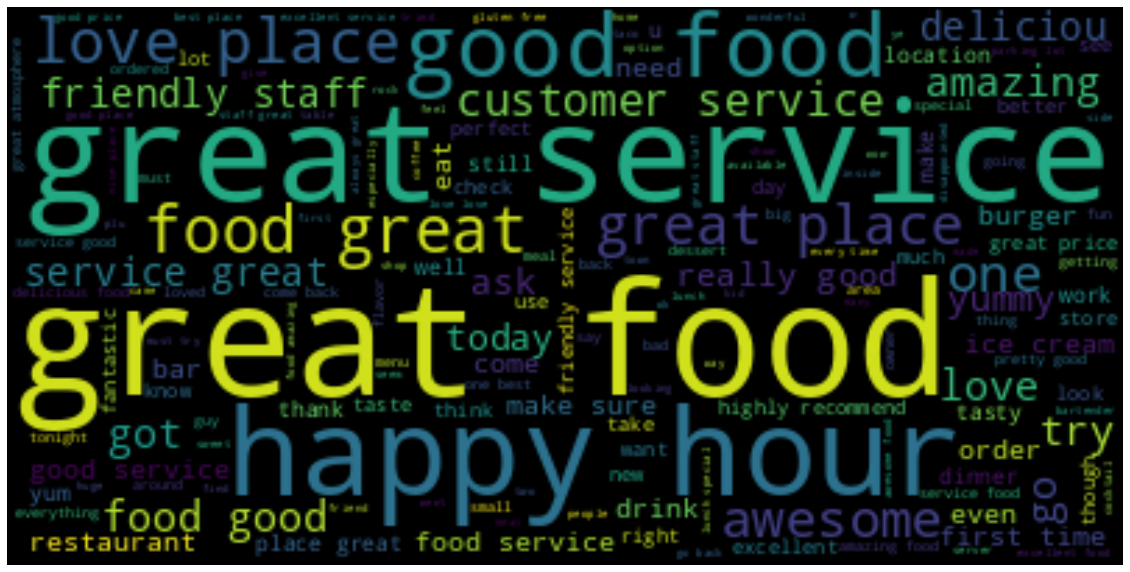

In [0]:
wordcloud = WordCloud().generate(' '.join(TWtipsPDF['key_words']))
# Generate plot
plt.figure(figsize=(20,20))
plt.axis("off")
plt.imshow(wordcloud, interpolation='bilinear')


## Modeling

### Logistic Regression
Predict is_open based on stars

In [0]:
reviewOpen = TWbusinessDFClean.select("review_count", "is_open", "overall_stars")

In [0]:
TWdataLog = TWbusinessDFClean.select("review_count", "overall_stars", "is_open")
TWdataLog1 = TWdataLog.toPandas()
#Split Data Set into Input Features and Outcome
X = TWdataLog1[TWdataLog1.columns[:-1]] #data.columns[:-1] = All columns excluding the last
y = TWdataLog1[TWdataLog1.columns[-1:]] #data.columns[-1] = The last columns 
#Splitting Data Into Training and Testing Set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50,stratify=y)
#Create a LogisticRegression classifier and fit the training data
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, np.ravel(y_train))
y_pred = lr.predict(X_test)

In [0]:
#measure accuarcy 
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,y_pred))

0.6307752930745739


In [0]:
from sklearn.model_selection import cross_val_score

lr2 = LogisticRegression()
result = cross_val_score(lr2, X_train, np.ravel(y_train), cv=10, scoring='accuracy') #Set to 10 fold cross validation
print("Result:", result)
print("Average:", np.mean(result))

Result: [0.63087909 0.63087909 0.63078818 0.63078818 0.63078818 0.63078818
 0.63078818 0.63078818 0.63078818 0.63078818]
Average: 0.6308063606357726


### Decision Tree
Predict stars based on review count and is open

In [0]:
TWdataTree = TWjoinClean.select("key_words", "overall_stars")

In [0]:
TWreviewOpenTree = TWbusinessDFClean.select("review_count", "is_open", "overall_stars")

In [0]:
TWdataTreePDF = TWreviewOpenTree.toPandas()
X = TWdataTreePDF[TWdataTreePDF.columns[:-1]] #data.columns[:-1] = All columns excluding the last
y = TWdataTreePDF[TWdataTreePDF.columns[-1:]]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50,stratify=y)
from sklearn.tree import DecisionTreeClassifier
tr = DecisionTreeClassifier(random_state=50)
tr.fit(X_train, y_train)

Out[85]: DecisionTreeClassifier(random_state=50)

In [0]:
tr.get_depth()

Out[86]: 42

In [0]:
for i in np.argsort(tr.feature_importances_):
    print(X_train.columns[i], tr.feature_importances_[i])

is_open 0.09914873420279889
review_count 0.9008512657972012


In [0]:
from sklearn.metrics import classification_report
print(classification_report(y_test, tr.predict(X_test)))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       227
           2       0.00      0.00      0.00      1362
           3       0.42      0.67      0.52      4195
           4       0.45      0.39      0.42      4085
           5       0.00      0.00      0.00       282

    accuracy                           0.43     10151
   macro avg       0.17      0.21      0.19     10151
weighted avg       0.36      0.43      0.38     10151

/databricks/python/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no pre

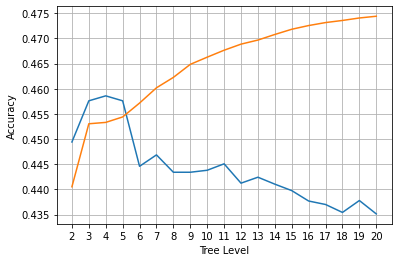

In [0]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
acc = []
training = []
for i in range(2, 21):
    tr = DecisionTreeClassifier(random_state=50, max_depth=i)
    tr.fit(X_train, y_train)
    acc.append(accuracy_score(y_test,tr.predict(X_test)))
    training.append(accuracy_score(y_train,tr.predict(X_train)))

plt.xticks(range(0,21))
plt.plot(range(2, 21), acc) #blue
plt.plot(range(2, 21), training)
plt.ylabel('Accuracy')
plt.xlabel('Tree Level')
plt.grid(True)
plt.show()

In [0]:
#max depth, 5 is the most accurate while having the shortest distance from training to actual 
tr2 = DecisionTreeClassifier(random_state=50, max_depth=5)
tr2.fit(X_train, y_train)

Out[91]: DecisionTreeClassifier(max_depth=5, random_state=50)

In [0]:
print(classification_report(y_test,tr2.predict(X_test)))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       227
           2       0.00      0.00      0.00      1362
           3       0.42      0.72      0.53      4195
           4       0.54      0.40      0.46      4085
           5       0.00      0.00      0.00       282

    accuracy                           0.46     10151
   macro avg       0.19      0.22      0.20     10151
weighted avg       0.39      0.46      0.40     10151

/databricks/python/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no pre